In [153]:
import numpy as np
from tqdm import tqdm
import random
import gymnasium as gym
# from gym.wrappers import Monitor
import glob
import io
import matplotlib.pyplot as plt
from IPython.display import HTML
from collections import deque

In [154]:
#Setting up the environment
env = gym.make('Taxi-v3', render_mode='ansi')
state, _ = env.reset()

# The state of the environment
print(state)

print("decoded state")
print(list(env.decode(state)))


#The number of states in the environment
print(env.observation_space.n)

#The number of actions in the environment
print(env.action_space.n)

#Take a step in the environment
next_state, reward, done, _, _ = env.step(1)
print("decoded state")
print(list(env.decode(next_state)))

#Render the environment
env.render()

333
decoded state
[3, 1, 3, 1]
500
6
decoded state
[2, 1, 3, 1]


'+---------+\n|R: | : :\x1bG\x1b|\n| : | : : |\n| :\x1b \x1b: : : |\n| | : | : |\n|Y| : |\x1bB\x1b: |\n+---------+\n  (North)\n'

[![Options](https://www.researchgate.net/publication/292208109/figure/fig2/AS:960497125978114@1606011768506/Taxi-problem-and-an-action-hierarchy.gif)]

In [155]:
# actions:  ['down', 'up', 'right', 'left', 'pickup', 'dropoff']
actions = [0, 1, 2, 3, 4, 5]


goal_states = [[0, 0], [0, 4], [4, 0], [4, 3]]

level_1_options = [0, 1]
# highest level options: ['get', 'put']

get_put_options = [0, 1, 2, 3, 4]
# get options: ['pickup/dropff', 'getR', 'getG', 'getY', 'getB']


navigate_options = [0, 1, 2, 3]
# navigate options: ['down', 'up', 'right', 'left']
Q_level_one_options = np.zeros((500, 2)) # Q-values for level options -> get/put

Q_level_two_options = np.zeros((2, 500, len(get_put_options))) # Q-values for level options -> get/put, toR, toG, toY, toB

Q_level_three_options = np.zeros((4, 25, len(navigate_options))) # Q-values for level options -> down, up, right, left


# Softmax function
def softmax(Q, state, tau):
    q_values = Q[state]
    q_values = q_values / tau
    max_q = np.max(q_values)
    e = np.exp(q_values - max_q)
    dist = e / np.sum(e)
    action = np.random.choice(len(dist), p=dist)
    return action

def epsilon_greedy(Q, state, epsilon):
    if random.uniform(0, 1) < epsilon:
        action = np.random.randint(0, 4)
    else:
        action = np.argmax(Q[state])
    return action

In [156]:
def decode_state(env, state):
    return list(env.decode(state))

In [157]:
### HYPERPARAMETERS ###
ALPHA_Q = 0.1
ALPHA_OPTIONS = 0.25
ALPHA_OPTIONS_1 = 0.4
GAMMA = 0.9
TAU = 1
DECAY_CONSTANT = 0.995

In [158]:
def execute_level_1_selection(env, state, Q_level_one_options, Q_level_two_options, Q_level_three_options, option, policy, TAU):
    """
    Execute the level 1 selection

    Args:
    env: the environment
    state: the current state
    level_1_options: the level 1 options
    Q_level_two_options: Q-values for level 2 options
    Q_level_three_options: Q-values for level 3 options
    policy: the policy to use

    Returns:
    next_state: the next state
    reward: the reward
    done: is the episode done
    Q_level_two_options: updated Q-values for level 2 options
    Q_level_three_options: updated Q-values for level 3 options
    """
    
    if option < 2:
        """
        Get the Q-values for the level 2 options based on the option chosen
        Initialize the reward bar to 0
        Initialize the counter to 0
        Initialize the current state to the current state
        Get the Q-values for the chosen option
        Update the Q-values for the chosen option based on the reward and the Q-values for the next state
        """
        optdone = False
        optact = 0
        counter = 0
        reward_bar = 0
        chosen_q = Q_level_two_options[option]
        steps = 0
        while not optdone:
            optact = policy(chosen_q, state, TAU)
            next_state, reward, done, [Q_level_two_options, Q_level_three_options], pick_drop_flag, steps_level_2 = execute_level_2_options(env, Q_level_two_options, Q_level_three_options, state, option, optact, policy, TAU)
            reward_bar += reward * GAMMA**counter
            steps += steps_level_2
            chosen_q[state][optact] += ALPHA_OPTIONS * (reward + GAMMA * np.max(chosen_q[next_state]) - chosen_q[state][optact])
            if pick_drop_flag:
                # print("Enters here")
                optdone = True
                Q_level_one_options[state][option] += ALPHA_Q * (reward - Q_level_one_options[state][option] + GAMMA * np.max(Q_level_one_options[next_state]))
            else:
                optdone = False
                Q_level_one_options[state][option] += ALPHA_Q * (reward - Q_level_one_options[state][option] + (Q_level_one_options[next_state][option]))
            counter += 1
            state = next_state
        Q_level_two_options[option] = chosen_q
        return next_state, reward_bar, done, [Q_level_one_options, Q_level_two_options, Q_level_three_options], steps
    # else:
    #     next_state, reward, done, _, _ = env.step(option-2)
    #     Q_level_one_options[state][option] += ALPHA_Q * (reward - Q_level_one_options[state][option] + GAMMA * np.max(Q_level_one_options[next_state]))
    #     steps = 1
    #     return next_state, reward, done, [Q_level_one_options, Q_level_two_options, Q_level_three_options], steps


def execute_level_2_options(env, Q_level_two_options, Q_level_three_options, state, option_level_1, option_level_2, policy, TAU):
    """
    Execute the level 2 options

    Args:
    env: the environment
    Q_level_two_options: Q-values for level 2 options
    Q_level_three_options: Q-values for level 3 options 
    state: the current state
    option: the selected option
    level_1_option: the selected level 1 option
    policy: the policy to use

    Returns:
    next_state: the next state
    reward: the reward
    done: is the episode done
    Q_level_two_options: updated Q-values for level 2 options
    Q_level_three_options: updated Q-values for level 3 options
    """
    optdone = False
    optact = 0
    if option_level_2 == 0: # pickup/dropoff
        """
        Pickup or dropoff
        If level 1 option is get, and option is 0, then pickup(4)
        If level 1 option is put, and option is 0, then dropoff(5)    
        """
        if option_level_1 == 0:
            chosen_action = 4
        elif option_level_1 == 1:
            chosen_action = 5
        steps = 1

        """
        Execute the action if it is pickup or dropoff
        Update the Q-values for the level 2 options based on the reward (500, 5)
        """
        next_state, reward, done, _, _ = env.step(chosen_action)
        state_decoded = decode_state(env, state)
        next_state_decoded = decode_state(env, next_state)
        PICKUP_REWARD = 30 if chosen_action==4 and state_decoded[2]!=4 and next_state_decoded[2]==4 else 0
        # DROP_REWARD = 15 if chosen_action==5 and state_decoded[2]==4 and next_state_decoded[2]!=4 else 0
        Q_level_two_options[option_level_1][state][option_level_2] +=  ALPHA_OPTIONS * (reward + PICKUP_REWARD + GAMMA * np.max(Q_level_two_options[option_level_1][next_state]) - Q_level_two_options[option_level_1][state][option_level_2])
        """
        If the next state is the goal state, then the option is done
        Returns the next state, reward, done, Q-values for level 2 options, Q-values for level 3 options
        """
        # print("Pickup or dropoff")
        return next_state, reward, done, [Q_level_two_options, Q_level_three_options], True, steps
    
    else: # getR, getG, getY, getB
        """
        If the option is not pickup/dropoff, then it is getR, getG, getY, getB
        Get the index of the chosen action
        Initialize the reward bar to 0
        Initialize the counter to 0
        Initialize the current state to the current state
        Based on the chosen action, get the Q-values for the chosen action (25, 4)
        """
        reward_bar = 0
        chosen_action_index = get_put_options.index(option_level_2) - 1
        counter = 0
        current_state = state
        chosen_q = Q_level_three_options[chosen_action_index]
        while not optdone:
            """
            While the option is not done, do the following:
            Decode the state
            Get the state value
            Get the action based on the policy and chosen Q-values(25, 4), state value, and tau 
            Execute the action
            Get the next state value
            Update the reward bar
            Update the Q-values for the chosen action based on the reward and the Q-values for the next state
            """
            state_value = 5 * decode_state(env, state)[0] + decode_state(env, state)[1]
            optact = policy(chosen_q, state_value, TAU)
            next_state, reward, done, _, _ = env.step(optact)
            next_state_value = 5 * decode_state(env, next_state)[0] + decode_state(env, next_state)[1]
            reward_bar += reward*GAMMA**counter

            action_array = []
            for i in range(len(Q_level_two_options)):
                for j in range(len(Q_level_two_options[i][state])):
                    if j!=0:
                        # print(i, j)
                        choose_option_array = policy(Q_level_three_options[j-1], state_value, TAU)
                        action_array.append([i, choose_option_array])
            if decode_state(env, next_state)[:2] == goal_states[chosen_action_index]:
                """
                If the next state is the goal state, then the option is done
                Update the Q-values for the level 2 options based on the reward bar and the Q-values for the next state based on the option chosen by level 3 options
                """
                # print("Goal state reached")
                optdone = True
            
                Q_level_two_options[option_level_1][state][option_level_2] += ALPHA_OPTIONS * \
                    (reward - Q_level_two_options[option_level_1][state][option_level_2] + \
                     GAMMA * np.max(Q_level_two_options[option_level_1][next_state]))
                for state_set in action_array:
                    # print(state_set, state, next_state)
                    Q_level_two_options[state_set[0]][state][state_set[1]] += ALPHA_OPTIONS * \
                    (reward - Q_level_two_options[state_set[0]][state][state_set[1]] + \
                     GAMMA * np.max(Q_level_two_options[state_set[0]][next_state]))
            else:
                optdone = False
                Q_level_two_options[option_level_1][state][option_level_2] += ALPHA_OPTIONS * \
                    (reward - Q_level_two_options[option_level_1][state][option_level_2] + \
                     GAMMA * (Q_level_two_options[option_level_1][next_state][option_level_2]))
                for state_set in action_array:
                    # print(state_set, state, next_state)                    
                    Q_level_two_options[state_set[0]][state][state_set[1]] += ALPHA_OPTIONS * \
                    (reward - Q_level_two_options[state_set[0]][state][state_set[1]] + \
                     GAMMA * (Q_level_two_options[state_set[0]][next_state][state_set[1]]))
            GOAL_REWARD = 30 if optdone else 0
            IN_TAXI_REWARD = -2 if option_level_1 == 1 and decode_state(env, state)[2]==4 else 0
            chosen_q[state_value][optact] += ALPHA_OPTIONS_1 * (reward + GOAL_REWARD + IN_TAXI_REWARD + GAMMA * np.max(chosen_q[next_state_value]) - chosen_q[state_value][optact])
            
            counter += 1
            state = next_state
        Q_level_three_options[chosen_action_index] = chosen_q
        steps = counter
        # print(reward_bar)
        return next_state, reward_bar, done, [Q_level_two_options, Q_level_three_options], False, steps
                
            

In [159]:
#### SMDP Q-Learning
episodes = 10000


def SMDP_Q_Learning(env, Q_level_one_options, Q_level_two_options, Q_level_three_options, policy, TAU, DECAY_CONSTANT, episodes):
    # Iterate over 10000 episodes
    total_rewards = np.zeros((episodes))
    for i in tqdm(range(episodes)):
        state, _ = env.reset()    
        done = False
        # While episode is not over
        episode_steps = 0
        while not done:
            option = softmax(Q_level_one_options, state, TAU)
            # Choose and execute the level 1 option
            next_state, reward, done, value_array, steps = execute_level_1_selection(env, state, Q_level_one_options, Q_level_two_options, Q_level_three_options, option, policy, TAU)
            Q_values_level_1, Q_values_level_2, Q_values_level_3 = value_array
            state = next_state
            total_rewards[i] += reward
            TAU = max(0.01, TAU * DECAY_CONSTANT)
            episode_steps += steps
            # print(episode_steps)

    return Q_values_level_1, Q_values_level_2, Q_values_level_3, total_rewards


In [160]:
Q_level_one_options, Q_level_two_options, Q_level_three_options, total_rewards = SMDP_Q_Learning(env, Q_level_one_options, Q_level_two_options, Q_level_three_options, epsilon_greedy, TAU, DECAY_CONSTANT, episodes)

100%|██████████| 10000/10000 [00:41<00:00, 243.88it/s]


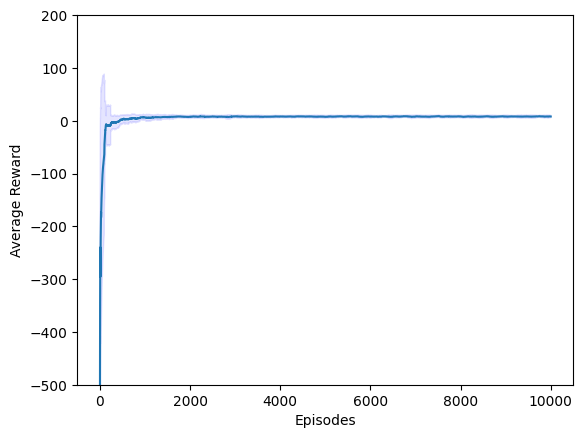

In [161]:
def plot_rewards(rewards):
    avg_rew = []
    std_dev = []
    plt.figure("Reward Plot")
    scores_window = deque(maxlen=100)
    for reward in rewards:
        scores_window.append(reward)
        avg_rew.append(np.mean(scores_window))
        std_dev.append(np.std(scores_window))
    plt.plot(avg_rew)
    plt.fill_between(range(len(avg_rew)), np.subtract(avg_rew, std_dev), np.add(avg_rew, std_dev), color='b', alpha=0.1)
    plt.xlabel('Episodes')
    plt.ylabel('Average Reward')
    plt.ylim(-500, 200)  # Set the Y-axis range

plot_rewards(total_rewards)

In [162]:
print(np.mean(total_rewards[-100:]))

7.989689644709999


In [163]:

def plot_Q_values(Q_level_one_options):
    
    PASSENGER_LOCATIONS = [0, 1, 2, 3, 4]
    PASSENGER_LOCATIONS_TEXT = ['R', 'G', 'Y', 'B', 'In Taxi']
    DESTINATIONS = [0, 1, 2, 3]
    DESTINATIONS_TEXT = ['R', 'G', 'Y', 'B']

    ACTIONS_OPTIONS = ['get','put']

    fig, ax = plt.subplots(5, 4, figsize=(20, 20))

    for PASS_LOC in PASSENGER_LOCATIONS:
        for DEST in DESTINATIONS:
            Q_MAP = np.zeros((5, 5, 2))
            for i in range(5):
                for j in range(5):
                    state = ((5*i + j) * 5 + PASS_LOC) * 4 + DEST
                    Q_MAP[i, j] = Q_level_one_options[state]
            
            ax[int(PASS_LOC), int(DEST)].imshow(np.argmax(Q_MAP, axis=2), cmap='YlOrBr')
            ax[int(PASS_LOC), int(DEST)].set_title(f"Passenger: {PASSENGER_LOCATIONS_TEXT[int(PASS_LOC)]}, Destination: {DESTINATIONS_TEXT[int(DEST)]}")
            ax[int(PASS_LOC), int(DEST)].axis('off')

            ax[int(PASS_LOC), int(DEST)].axvline(x=0.5, ymin=-1, ymax=0.4, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.5, ymin=1, ymax=0.6, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=2.5, ymin=-1, ymax=0.4, color='blue', linewidth=5)


            for i in range(5):
                for j in range(5):
                    state = (5*i + j)*4 + int(PASS_LOC)*4 + int(DEST)
                    anno = ACTIONS_OPTIONS[np.argmax(Q_MAP[i,j])]
                    size='medium'
                    ax[int(PASS_LOC), int(DEST)].text(j , i, anno, ha='center', va='center', color='black', size=size)

    plt.show()


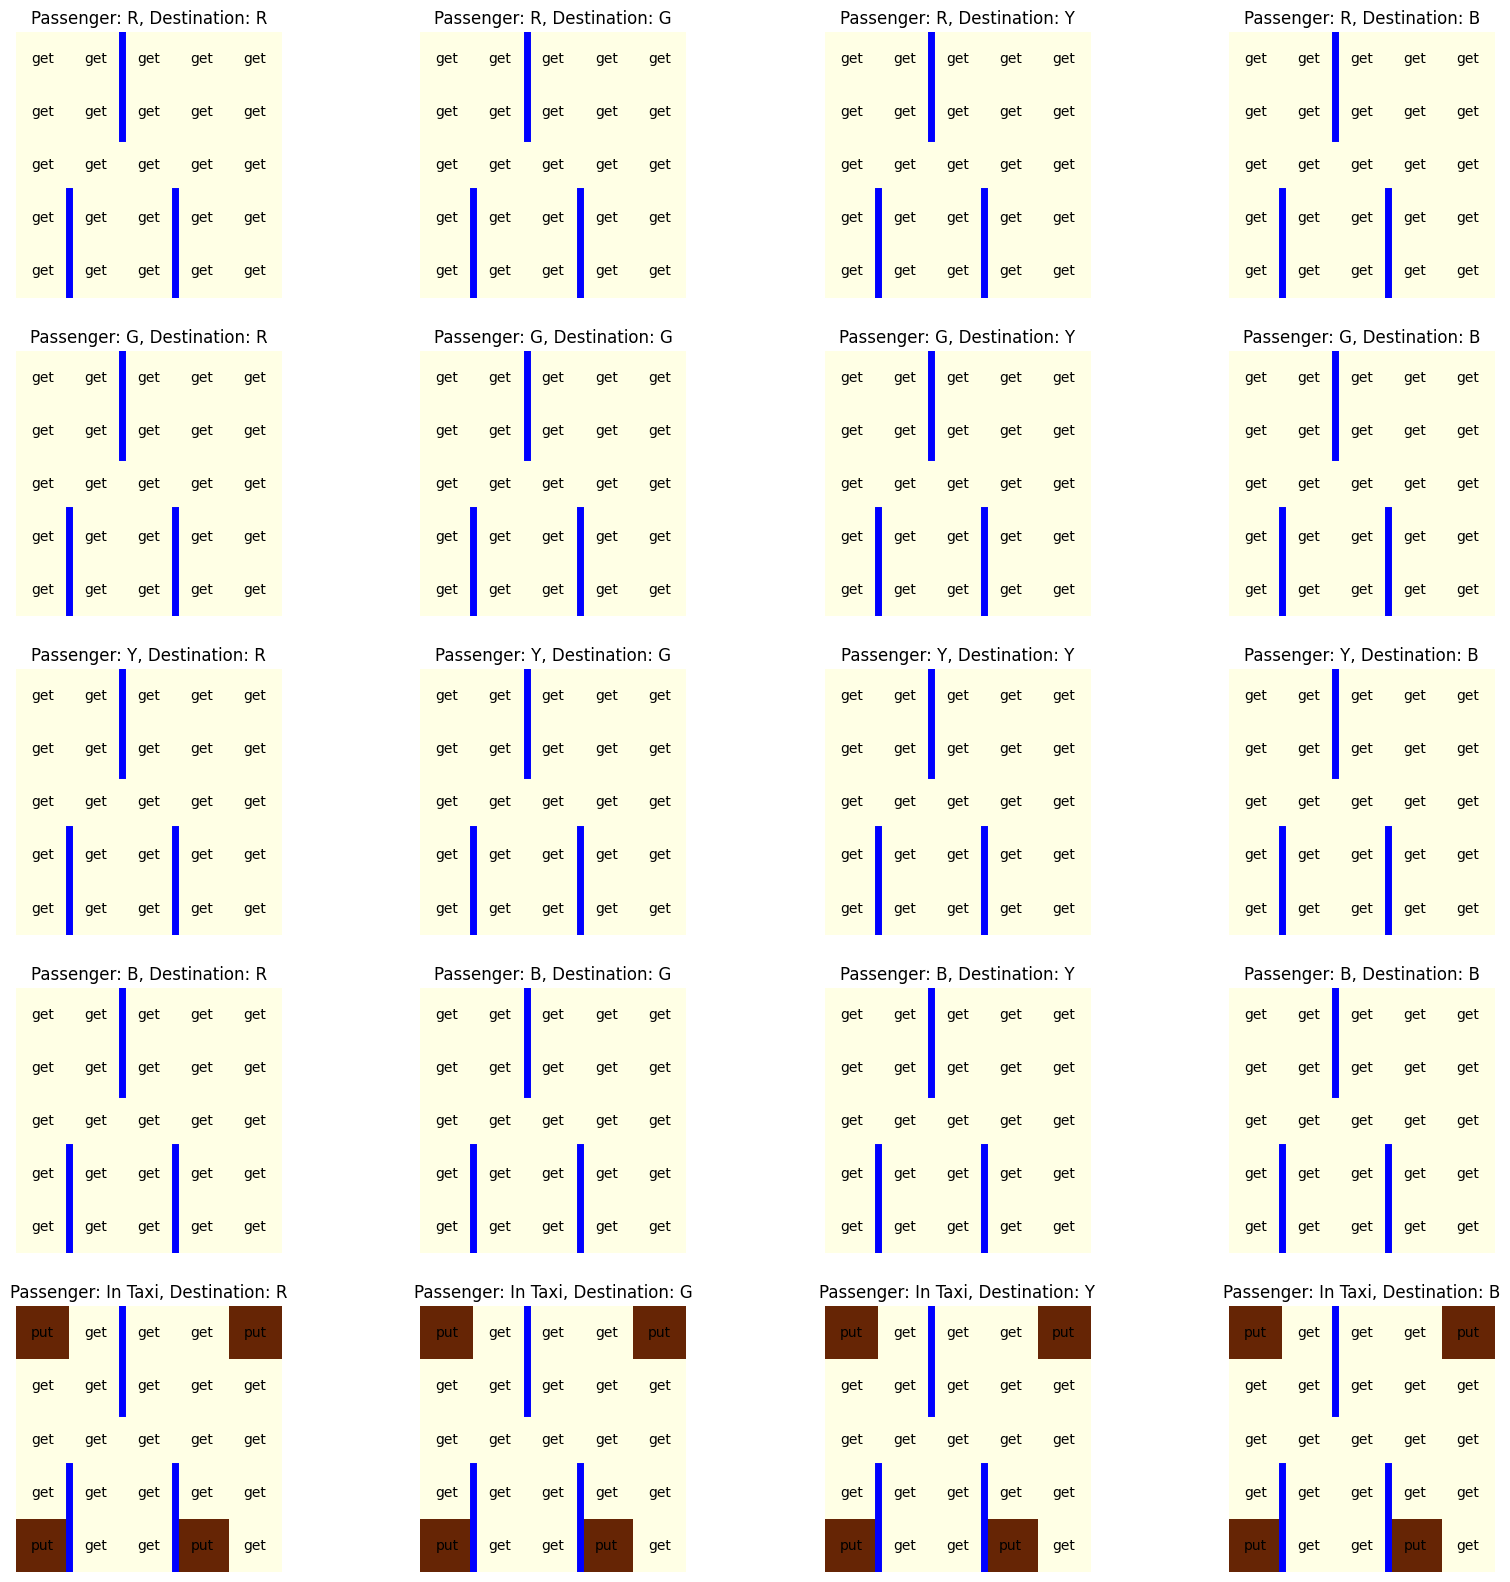

In [164]:
plot_Q_values(Q_level_one_options)

In [165]:

def plot_Q_values(Q_level_two_options, pick_drop):
    
    PASSENGER_LOCATIONS = [0, 1, 2, 3, 4]
    PASSENGER_LOCATIONS_TEXT = ['R', 'G', 'Y', 'B', 'In Taxi']
    DESTINATIONS = [0, 1, 2, 3]
    DESTINATIONS_TEXT = ['R', 'G', 'Y', 'B']

    ACTIONS_OPTIONS = [pick_drop, 'getR', 'getG', 'getY', 'getB']

    fig, ax = plt.subplots(5, 4, figsize=(20, 20))


    for PASS_LOC in PASSENGER_LOCATIONS:
        for DEST in DESTINATIONS:
            Q_MAP = np.zeros((5, 5, 5))
            for i in range(5):
                for j in range(5):
                    state = ((5*i + j) * 5 + PASS_LOC) * 4 + DEST
                    Q_MAP[i, j] = Q_level_two_options[state]
            
            ax[int(PASS_LOC), int(DEST)].imshow(np.argmax(Q_MAP, axis=2), cmap='YlOrBr')
            ax[int(PASS_LOC), int(DEST)].set_title(f"Passenger: {PASSENGER_LOCATIONS_TEXT[int(PASS_LOC)]}, Destination: {DESTINATIONS_TEXT[int(DEST)]}")
            ax[int(PASS_LOC), int(DEST)].axis('off')

            ax[int(PASS_LOC), int(DEST)].axvline(x=0.5, ymin=-1, ymax=0.4, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=1.5, ymin=1, ymax=0.6, color='blue', linewidth=5)
            ax[int(PASS_LOC), int(DEST)].axvline(x=2.5, ymin=-1, ymax=0.4, color='blue', linewidth=5)


            for i in range(5):
                for j in range(5):
                    state = (5*i + j)*4 + int(PASS_LOC)*4 + int(DEST)
                    anno = ACTIONS_OPTIONS[np.argmax(Q_MAP[i,j])]
                    size='medium'
                    ax[int(PASS_LOC), int(DEST)].text(j , i, anno, ha='center', va='center', color='black', size=size)

    plt.show()


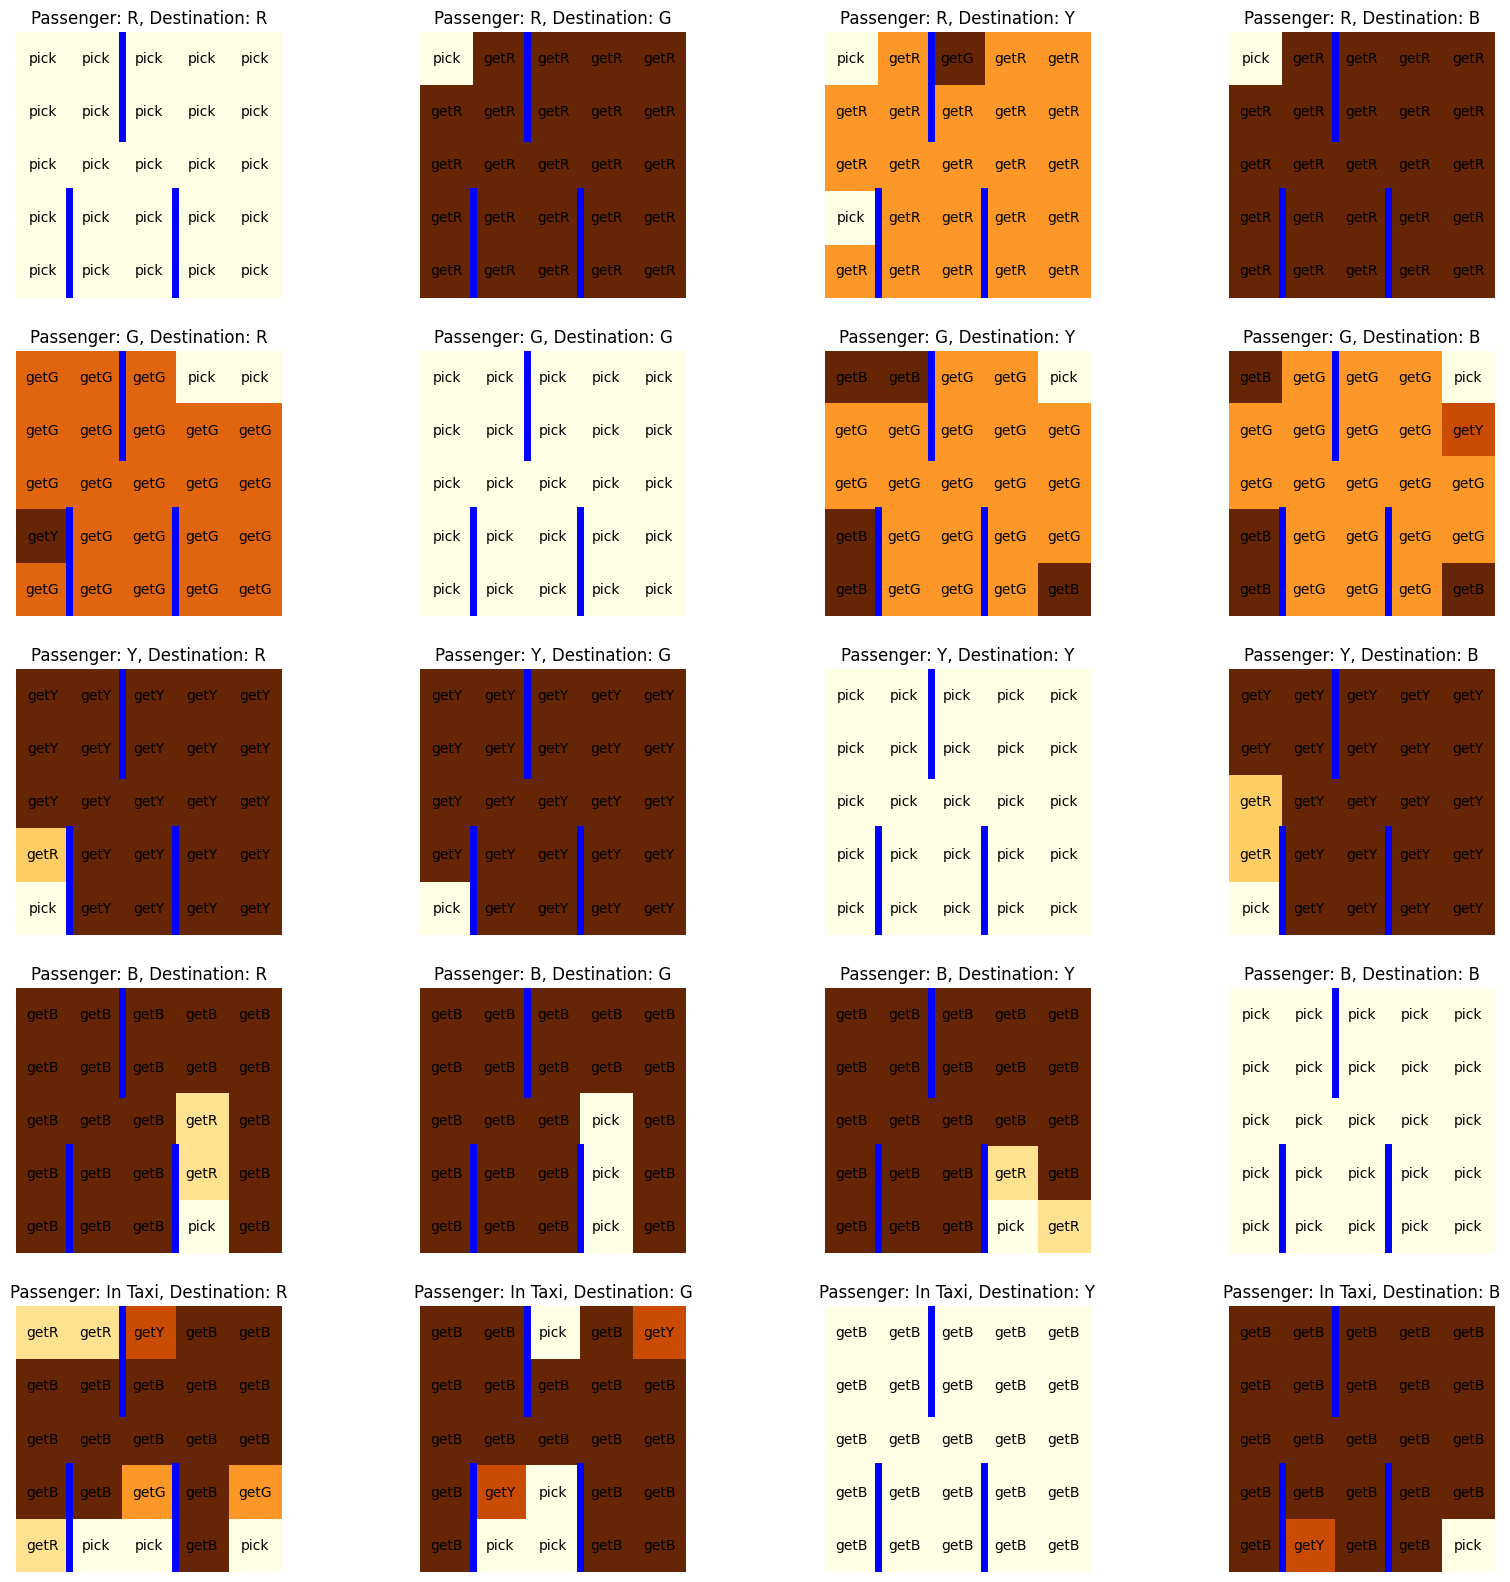

In [166]:
plot_Q_values(Q_level_two_options[0], 'pick')

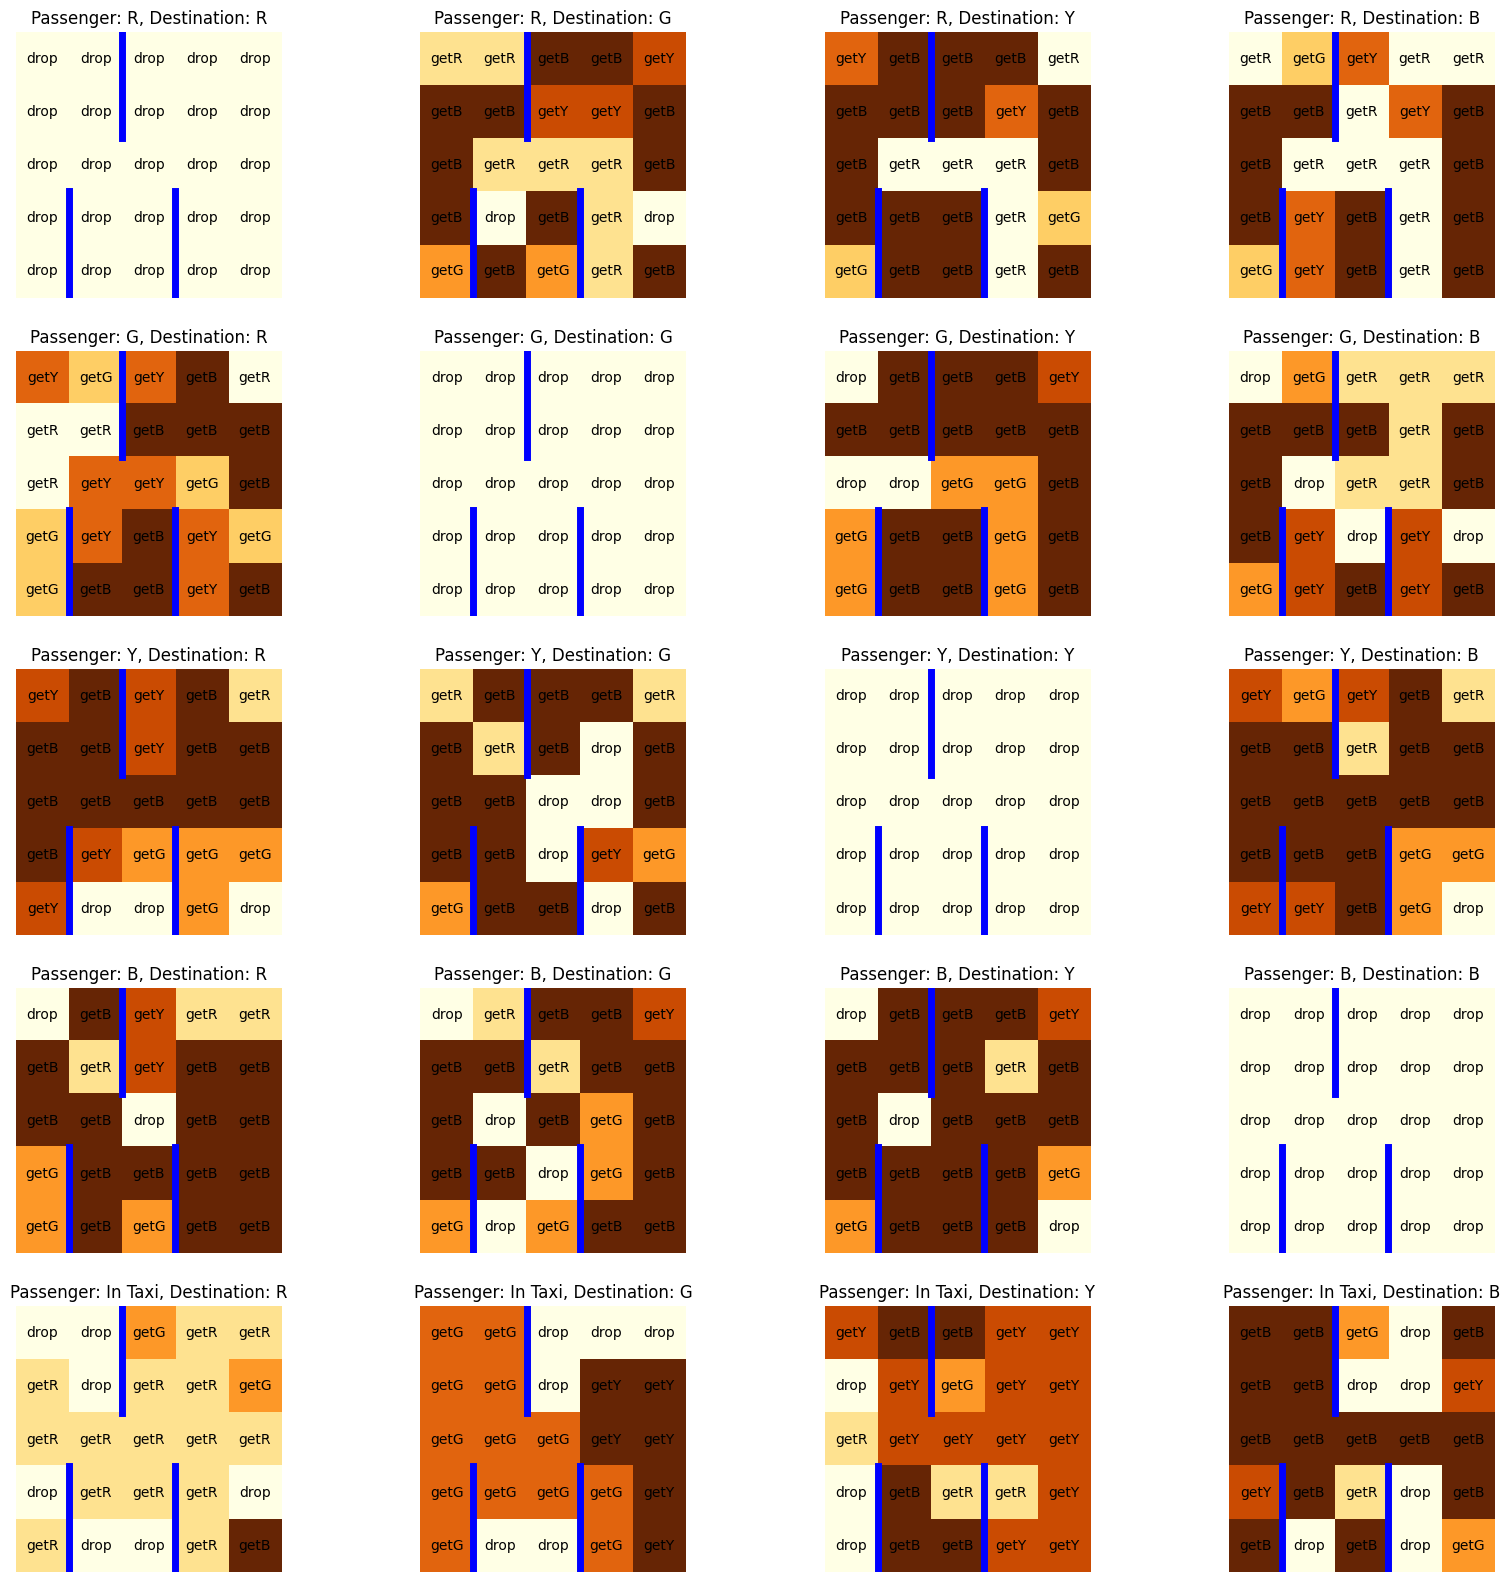

In [167]:
plot_Q_values(Q_level_two_options[1], 'drop')